# GVFs and Successor Representation 



---

This is a report on the topic of Successor Representation (SR). The idea of the Successor Representation is to see the rows of $(I-\gamma P_\pi)^{-1}$ as defining features. A row $s$ of that matrix in fact corresponds to the expected (discounted) occupancy over future states given that the agent with policy $\pi$ started in state $s$. In the tabular case, the feature vector $\phi_\pi$ (of length of the number of states) is defined as:
$$\phi_\pi(s)=e_s^T(I-\gamma P_\pi)^{-1}$$
This report has $5$ sections as listed below:


1.   **SR as General Value Functions (GVF):** In this section we will explain how SR can be expressed in the GVF framework.
2.   **Learning SR:** In this section we attempt to learn SR using a $\mathrm{TD}(0)$ update rule.
3.   **Value Prediction with SR:** Using the SR learned in the previous section, we will predict the value function for $\pi$.
4.   **Tracking with SR**: Testing the capacity of SR by abruptly changing the reward function during training and monitoring the effect.
5.   **Eigendecomposition**: Given the SR (the exact value), we will compute its eigendecomposition and plot some of its eigenvectors.



## 1.  SR as General Value Functions (GVF)
In this section we aim to explain how SR can be expressed in the GVF framework using the GVF terminology: cumulant, termination condition, etc.

SR is defined as the expected (discounted) occupancy over future states given that the agent with policy $\pi$ started in state $s$. In the GVF framework the GVF is given by a policy, termination function, cumulant, and terminal reward function. By definition SR receive the policy $\pi$ as the agent policy. Its value is determined by the expected discounted occupancy over future states. How we would like to discount it determines its termination function, which in our formulation the termination function is the constant function $\gamma$. The cumulant of this GVF is, as stated, the occupancy over the future states. This can simply be the number of times that state is going to be occupied on average in the future. We can simply add one each time we visit a particular state so we can measure its occupancy. In our setting the terminal reward function $z$ is zero. Putting all these together the the expected discounted occupancy over future states, following policy $\pi$, starting in state $s$ can be written as the vector $\phi_\pi(s)$ where its $j^{th}$ component is given by:
  $$\phi_\pi(s)_j=\mathbb{E}\left[ \sum_{t=0}^{\infty}\gamma^t\mathbb{I}(s_t=j) |s_0=s \right]$$
Here $\mathbb{I}$ is the indicator function. In this formulation we captured what we discussed above. The indicator function basically counts the number of times state $j$ is visited in the future starting from state $s$ by providing a cumulant of $1$ for each visit and cumulant of $0$ when the visited state is not $j$. Note that as we discussed before there is a termination function ($\gamma$) that exponentially decreases the cumulant (occupancy of future sates) in our formulation as we desired.

## 2. Learning SR
In this section we are going to learn SR using a $\mathrm{TD}(0)$ update rule in the [FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/) environment of Gym. However the actions will be deterministic in our implementation of the environment, i.e. the environment will not be *"slippery"*! The policy $\pi$ under which we will learn SR is a random policy, giving an equal probability to each action in our environment (since we have $4$ actions this probability is $0.25$). We are also going to compute $\phi_\pi(s)=e_s^T(I-\gamma P_\pi)^{-1}$ exactly and investigate if our learning algorithm converges to this exact value or not.

In [1]:
# !pip install gym
import gym
import numpy as np
from numpy.linalg import inv
from sklearn.preprocessing import normalize
from numpy import linalg as LA
import matplotlib.pyplot as plt

### 2.1  Environment Creation
Below we are modifying the Gym [FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/) environment so that the actions in the environment would be deterministic i.e. turning off the slipperiness!

In [2]:
from gym.envs.registration import register
register(
    id='FrozenLakeNS-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
)

### 2.2 Calculating The Exact Value of $\phi_\pi$
The function below will receive as input the values of $\gamma$ as **gamma**, $P_\pi$ as **p** and state $s$ as **state**. If the input **state** is given by the numerical value of the state then the reutn would be $\phi_\pi(s)$ and if it is set to **No** then the return would be the entire matrix of $\phi_\pi$. 

In [3]:
def feature_computer(state,p,gamma):
  if state=="No":
    I=np.identity(p.shape[1])
    phi=inv(I-gamma*p)
  else:
    I=np.identity(p.shape[1])
    phi=inv(I-gamma*p)[state,:]
  return phi

For our environment, we calculated the exact value of matrix $P_\pi$ and we present it below in the variable **p**. We then pursue to compute the exact value of the matrix $\phi_\pi$ and store it into the variable **true_val**.

In [0]:
p=np.array([[0.5,0.25,0,0,0.25,0,0,0,0,0,0,0,0,0,0,0]
          ,[0.25,0.25,0.25,0,0,0.25,0,0,0,0,0,0,0,0,0,0]
          ,[0,0.25,0.25,0.25,0,0,0.25,0,0,0,0,0,0,0,0,0]
          ,[0,0,0.25,0.5,0,0,0,0.25,0,0,0,0,0,0,0,0]
          ,[0.25,0,0,0,0.25,0.25,0,0,0.25,0,0,0,0,0,0,0]
          ,[0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]
          ,[0,0,0.25,0,0,0.25,0,0.25,0,0,0.25,0,0,0,0,0]
          ,[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]
          ,[0,0,0,0,0.25,0,0,0,0.25,0.25,0,0,0.25,0,0,0]
          ,[0,0,0,0,0,0.25,0,0,0.25,0,0.25,0,0,0.25,0,0]
          ,[0,0,0,0,0,0,0.25,0,0,0.25,0,0.25,0,0,0.25,0]
          ,[0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]
          ,[0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]
          ,[0,0,0,0,0,0,0,0,0,0.25,0,0,0.25,0.25,0.25,0]
          ,[0,0,0,0,0,0,0,0,0,0,0.25,0,0,0.25,0.25,0.25]
          ,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])
gamma=0.25
state='No'
true_val=feature_computer(state,p,gamma)

### 2.3 SR Approxiamtion
Below we will learn the value of SR a $\mathrm{TD}(0)$ update rule. We let the our learning happen over $100,000$ episodes and each episode will be explored for a maximum of $100$ steps. The learning rate is set to be $0.001$ and $\gamma=0.25$. The value of learning rate was found by try and error and the value of $\gamma$ was picked arbitrarily. The matrix $M$ will hold the approximate value of SR. After each iteration we measure the norm of the difference between the exact and approximate SR to investigate the convergence of the learned SR to the exact true value of SR.

In [0]:
M=np.zeros([16,16])
rl=0.001
epochs=100000
error=np.zeros(epochs)
gamma=0.25
for i in range(epochs):
  env = gym.make('FrozenLakeNS-v0')
  observation_old=env.reset()
  for t in range(100):
    observation_new, reward, done, info = env.step(env.action_space.sample())
    M[observation_old,:]=M[observation_old,:]+rl*(gamma*M[observation_new,:]-M[observation_old,:])
    M[observation_old,observation_old]=M[observation_old,observation_old]+rl
    observation_old=observation_new
  error[i]=LA.norm(true_val-M)
  if (i/epochs)*100%10==0:
    print('Processing ', (i/epochs)*100, "% of the work.")


Processing  0.0 % of the work.
Processing  10.0 % of the work.
Processing  20.0 % of the work.
Processing  30.0 % of the work.
Processing  40.0 % of the work.
Processing  50.0 % of the work.
Processing  60.0 % of the work.
Processing  70.0 % of the work.
Processing  80.0 % of the work.
Processing  90.0 % of the work.


### 2.4  Plot Of Convergence of learned SR
Below we can see the convergence of the learned SR to the exact SR as their norm difference approaches to zero. For this plot we divided the norm difference by the norm of the exact SR and multiplied it by $100$ to get a sense of how close the learned SR is from the exact SR. Since we initialized the learned SR to zero we can see that at the beginning the error is $100 \%$. The error then decreases over the coarse of training to $0.43\%$. One can implement the above algorithm with higher number of iterations to achieve even lower error rates but we think $99.57\%$ accuracy is well beyond the level of accuracy required for our task. 

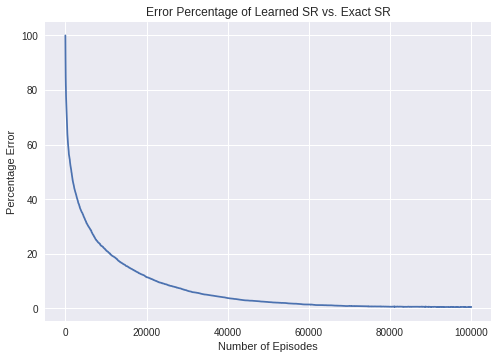

In [0]:
plt.plot((error/error[0])*100)
plt.title('Error Percentage of Learned SR vs. Exact SR')
plt.xlabel('Number of Episodes')
plt.ylabel('Percentage Error')
plt.show()

### 2.5 Plot of Prediction of Future Occupancy
Below we provided $16$ heat map plots presenting the prediction of future occupancy of other states given that we start at some state $s$. The values for these maps are the values we learned for SR in the section labeled **SR Approximation**.

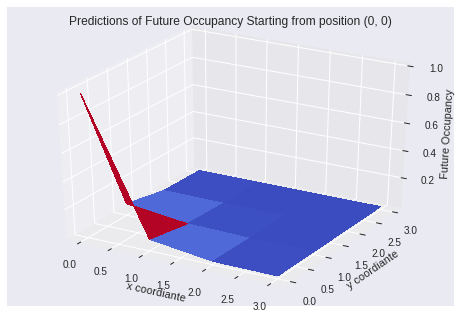

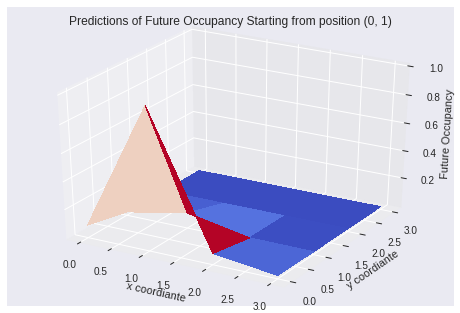

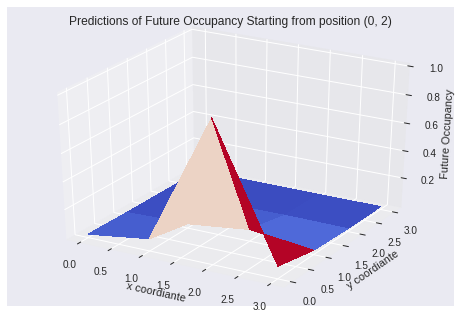

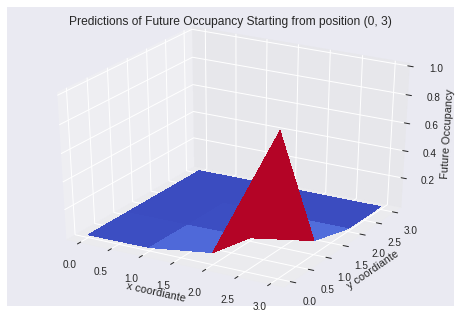

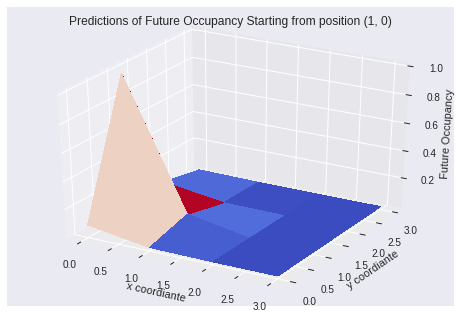

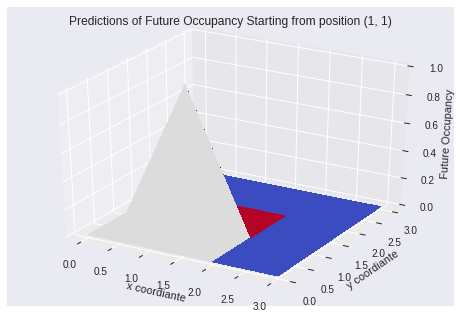

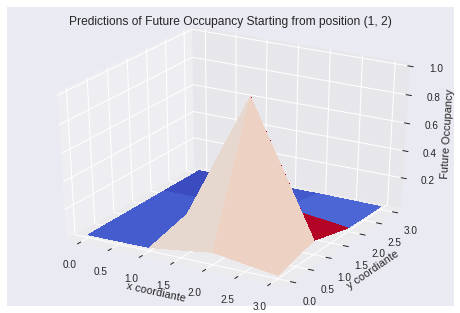

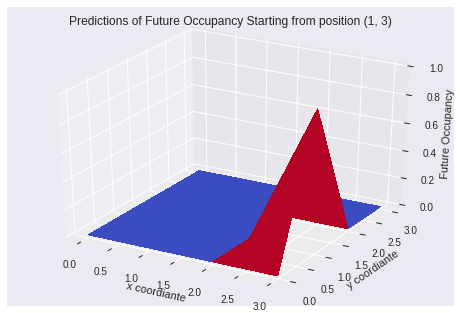

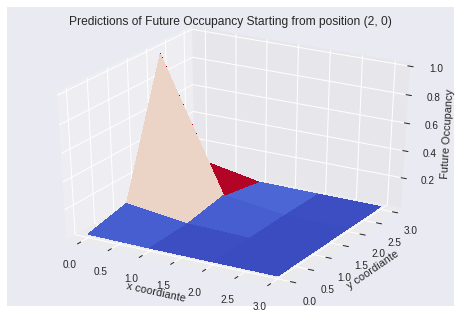

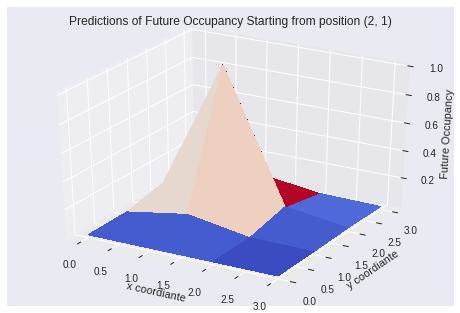

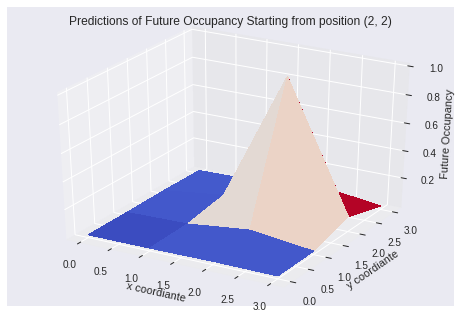

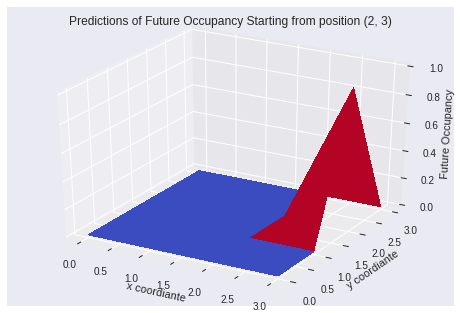

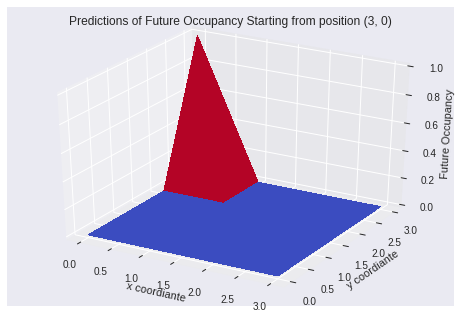

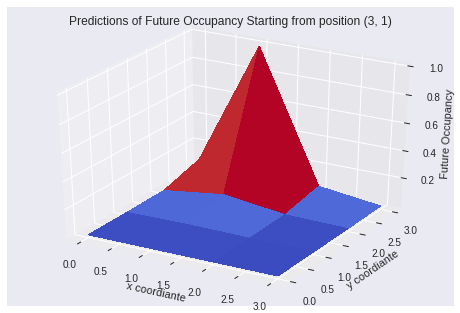

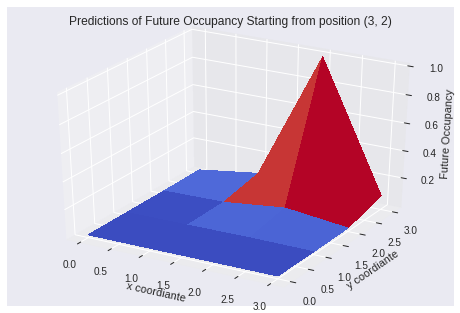

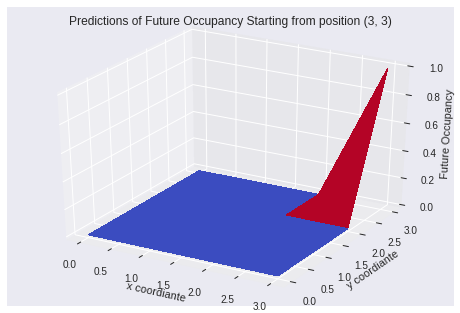

In [0]:
from mpl_toolkits.mplot3d import Axes3D

X=np.array([0,1,2,3])
Y=np.array([0,1,2,3])
X, Y = np.meshgrid(X, Y)
for i in range(16):  
  Z=M[i,:].reshape(4,4)/np.max(M[i,:])
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  ax.set_xlabel('x coordiante')
  ax.set_ylabel('y coordiante')
  ax.set_zlabel('Future Occupancy')
  ax.set_title('Predictions of Future Occupancy Starting from position {}'.format((i//4,i%4)))
  Axes3D.plot_surface(ax,X, Y, Z,cmap='coolwarm', antialiased=False)

## 3. Value Prediction With SR
In this part we will use the SR learned in the previous section (**Learning SR**) to predict the value function for our policy $\pi$ with the reward function given zero everywhere except $1$ at the goal state indicated as $G$ in the Gym documentation (position $15$). In this manner the $r_\pi=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.25,0]$. In order to compute the value function using SR, all we need to do is to compute the following inner product:
$$V_\pi(s)=\phi_\pi(s)^Tr_\pi$$
We will also use a $\mathrm{TD}(0)$ method to find the value function here that would allow us to compare it with the value function found from our SR approach.

To learn the value function using the $\mathrm{TD}(0)$ method below, we chose to iterate for $100,000$ episodes, and chose the learning rate (by trial and error) to be $0.001$ with $\gamma=0.25$ chosen arbitrarily.

In [0]:
v_TD=np.zeros(16)
rl=0.001
epochs=100000
gamma=0.25
for i in range(epochs):
  env = gym.make('FrozenLakeNS-v0')
  observation_old=env.reset()
  for t in range(100):
    observation_new, reward, done, info = env.step(env.action_space.sample())
    v_TD[observation_old]=v_TD[observation_old]+rl*(reward+gamma*v_TD[observation_new]-v_TD[observation_old])
    observation_old=observation_new
    if done:
      break
  if ((i/epochs)*100)%10==0:
    print("Work has been ",(i/epochs)*100, "% completed!")

Work has been  0.0 % completed!
Work has been  10.0 % completed!
Work has been  20.0 % completed!
Work has been  30.0 % completed!
Work has been  40.0 % completed!
Work has been  50.0 % completed!
Work has been  60.0 % completed!
Work has been  70.0 % completed!
Work has been  80.0 % completed!
Work has been  90.0 % completed!


### 3.1 Plot of VF comparison with TD(0) and SR
As we can see from the plot below the value function computed for each state under both methods is almost identical, hence our approach to value function computation using SR was a success.

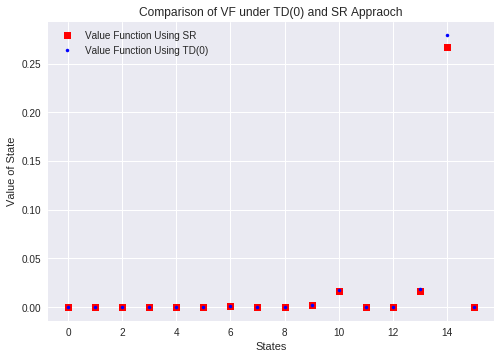

In [0]:
r_pi=np.zeros([16,1])
r_pi[14]=0.25
v_rs=np.dot(M,r_pi)#computing the inner product to find the value function with SR

plt.plot(v_rs,'rs',label='Value Function Using SR')
plt.plot(v_TD,'b.',label='Value Function Using TD(0)')
plt.xlabel('States')
plt.ylabel('Value of State')
plt.title ('Comparison of VF under TD(0) and SR Appraoch')
plt.legend()
plt.show()

In [0]:
np.sum(np.power(v_rs.flatten()-v_TD.flatten(),2))

0.00013591532935048974

Below we are basically doing the same comparison as we did above but here we are using a heat map of the value functions under both approach. Again we can clearly see that therE is no noticeable difference between the two as we expected.

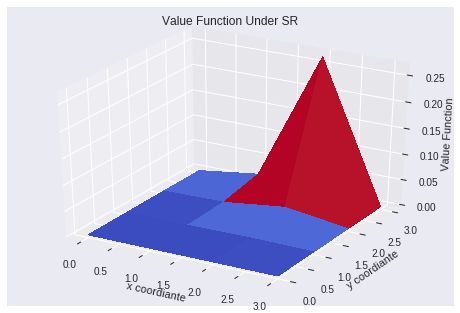

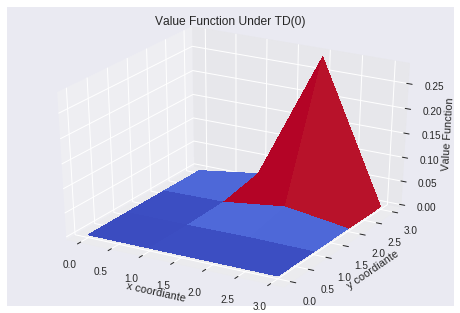

In [0]:
X=np.array([0,1,2,3])
Y=np.array([0,1,2,3])
X, Y = np.meshgrid(X, Y)
Z=v_rs.reshape(4,4)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('x coordiante')
ax.set_ylabel('y coordiante')
ax.set_zlabel('Value Function')
ax.set_title('Value Function Under SR')
Axes3D.plot_surface(ax,X, Y, Z,cmap='coolwarm', antialiased=False)

Z=v_TD.reshape(4,4)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('x coordiante')
ax.set_ylabel('y coordiante')
ax.set_zlabel('Value Function')
ax.set_title('Value Function Under TD(0)')
Axes3D.plot_surface(ax,X, Y, Z,cmap='coolwarm', antialiased=False)

## 4. Tracking with SR
In this section we will learn the value function for our random policy $\pi$ and reward function $r_1$ and after $20,000$ episodes we change the reward function abruptly to $r_2$.


*   $r_1$: The agent receives a reward of $+100$ once it reaches the goal state G. (*see [Gym documentation](https://gym.openai.com/envs/FrozenLake-v0/) for the location of the goal state*)
*   $r_2$: The agent receives a reward of $-1$ for every transition, and a reward of $+1$ at the goal state G.


In our analysis we will compare the error obtained from:


*   Just plain tabular $\mathrm{TD}(0)$ value prediction 
*   The value prediction error under the current SR features learned under the same $\mathrm{TD}(0)$ update rule as in part 1.


We would expect here that the SR approach would not be affected by the sudden change to $r_2$ (because $P_\pi$ doesn’t change), whereas the direct $\mathrm{TD}(0)$ agent would struggle to recover from the perturbation (the error will spike up).


### 4.1  Ground Truth for Error Calculations
In this section we will use a $\mathrm{TD}(0)$ method to evaluate the value function for our random policy $\pi$ with the reward functions $r_1$ and $r_2$. We are using these value functions as estimates of the true value functions for the policy $\pi$ and reward functions $r_1$ and $r_2$. In the next sections we will use these ground truths to compute the error when implementing the $\mathrm{TD}(0)$, and SR method mentioned above. In order to find the value functions for these $2$ reward functions, we will run our model for $100,000$ episodes of maximum $100$ steps. The learning rate we are using is $0.001$ and the value of $\gamma=0.9$.

#### 4.1.1 Ground Truth $r_1$ 
As previously explained, below is where we will compute the ground truth for the value function of the policy $\pi$ and the reward function $r_1$ with the same hyper parameters as mentioned before.

In [18]:
v_TD_r1=np.zeros(16)
rl=0.001
epochs=100000
gamma=0.9
for i in range(epochs):
  env = gym.make('FrozenLakeNS-v0')
  observation_old=env.reset()
  for t in range(100):
    observation_new, reward, done, info = env.step(env.action_space.sample())
    if reward==1:
      reward=100
    v_TD_r1[observation_old]=v_TD_r1[observation_old]+rl*(reward+gamma*v_TD_r1[observation_new]-v_TD_r1[observation_old])
    observation_old=observation_new
    if done:
      break
  if ((i/epochs)*100)%10==0:
    print("Work has been ",(i/epochs)*100, "% completed!")

Work has been  0.0 % completed!
Work has been  10.0 % completed!


KeyboardInterrupt: 

#### 4.1.2 Ground Truth $r_2$ 
As previously explained, below is where we will compute the ground truth for the value function of the policy $\pi$ and the reward function $r_2$ with the same hyper parameters as mentioned before.

In [0]:
v_TD_r2=np.zeros(16)
rl=0.001
epochs=100000
gamma=0.9
for i in range(epochs):
  env = gym.make('FrozenLakeNS-v0')
  observation_old=env.reset()
  for t in range(100):
    observation_new, reward, done, info = env.step(env.action_space.sample())
    if reward==0:
      reward=-1
    v_TD_r2[observation_old]=v_TD_r2[observation_old]+rl*(reward+gamma*v_TD_r2[observation_new]-v_TD_r2[observation_old])
    observation_old=observation_new
    if done:
      break
  if ((i/epochs)*100)%10==0:
    print("Work has been ",(i/epochs)*100, "% completed!")

Work has been  0.0 % completed!
Work has been  10.0 % completed!
Work has been  20.0 % completed!
Work has been  30.0 % completed!
Work has been  40.0 % completed!
Work has been  50.0 % completed!
Work has been  60.0 % completed!
Work has been  70.0 % completed!
Work has been  80.0 % completed!
Work has been  90.0 % completed!


### 4.2  Predicting The Value Function Under $\mathrm{TD}(0)$
Below we will train our $\mathrm{TD}(0)$ model with policy $\pi$ and reward function $r_1$ for $20,000$ episodes, then switch to the reward function $r_2$ for another $20,000$ episodes (with a maximum of $100$ steps per episode). In each part, in order to compute our error, we compute the norm difference of the value function we found below and the ground truths found in the previous section.

In [0]:
v_TD_change=np.zeros(16)
rl=0.001
epochs=20000
error_TD_change=np.zeros(2*epochs)
gamma=0.9
for i in range(epochs):
  env = gym.make('FrozenLakeNS-v0')
  observation_old=env.reset()
  for t in range(100):
    observation_new, reward, done, info = env.step(env.action_space.sample())
    if reward==1:
      reward==100
    v_TD_change[observation_old]=v_TD_change[observation_old]+rl*(reward+gamma*v_TD_change[observation_new]-v_TD_change[observation_old])
    observation_old=observation_new
    if done:
      break
  error_TD_change[i]=LA.norm(v_TD_r1-v_TD_change)
  if ((i/epochs)*100)%10==0:
    print("Work for task 1, has been ",(i/epochs)*100, "% completed!")
    
print('\n *** Starting task 2. ***\n')
    
for i in range(epochs):
  env = gym.make('FrozenLakeNS-v0')
  observation_old=env.reset()
  for t in range(100):
    observation_new, reward, done, info = env.step(env.action_space.sample())
    if reward==0:
      reward==-1    
    v_TD_change[observation_old]=v_TD_change[observation_old]+rl*(reward+gamma*v_TD_change[observation_new]-v_TD_change[observation_old])
    observation_old=observation_new
    if done:
      break
  error_TD_change[epochs+i]=LA.norm(v_TD_r2-v_TD_change)
  if ((i/epochs)*100)%10==0:
    print("Work for task 2, has been ",(i/epochs)*100, "% completed!")    

Work for task 1, has been  0.0 % completed!
Work for task 1, has been  10.0 % completed!
Work for task 1, has been  20.0 % completed!
Work for task 1, has been  30.0 % completed!
Work for task 1, has been  40.0 % completed!
Work for task 1, has been  50.0 % completed!
Work for task 1, has been  60.0 % completed!
Work for task 1, has been  70.0 % completed!
Work for task 1, has been  80.0 % completed!
Work for task 1, has been  90.0 % completed!

 *** Starting task 2. ***

Work for task 2, has been  0.0 % completed!
Work for task 2, has been  10.0 % completed!
Work for task 2, has been  20.0 % completed!
Work for task 2, has been  30.0 % completed!
Work for task 2, has been  40.0 % completed!
Work for task 2, has been  50.0 % completed!
Work for task 2, has been  60.0 % completed!
Work for task 2, has been  70.0 % completed!
Work for task 2, has been  80.0 % completed!
Work for task 2, has been  90.0 % completed!


### 4.3 Predicting The Value Function Under SR With $\mathrm{TD}(0)$
Below we will train our SR model with policy $\pi$ and reward function $r_1$ for $20,000$ episodes, then switch to the reward function $r_2$ for another $20,000$ episodes. During the training we are basically doing a "Value Function Approximation" where $\hat{v}(w,s)=w^Tx(s)$ (i.e. linear). Here $x(s)$ is the feature vector, in our setting the feature vector is the one we get from the SR method i.e. $\phi_\pi(s)$. For this approximation to work we basically need to compute the optimal $w$ along with our feature vector. In every time step of every episode we keep updating the values of both $w$ and $\phi$ (in the code as **M_est**) by $\mathrm{TD}(0)$.  In each part, in order to compute our error, we compute the norm difference of the value function we found below with the ground truths found in the previous section.

In [0]:
w_est=np.zeros(16)
M_est=np.zeros([16,16])
rl=0.001
epochs=20000
error_est=np.zeros(2*epochs)
gamma=0.9
for i in range(epochs):
  env = gym.make('FrozenLakeNS-v0')
  observation_old=env.reset()
  for t in range(100):
    observation_new, reward, done, info = env.step(env.action_space.sample())
    if reward==1:
      reward=100
    M_est[observation_old,:]=M_est[observation_old,:]+rl*(gamma*M_est[observation_new,:]-M_est[observation_old,:])
    M_est[observation_old,observation_old]=M_est[observation_old,observation_old]+rl
    
    w_est=w_est+rl*(reward+gamma*np.dot(w_est,M_est[observation_new,:])-np.dot(w_est,M_est[observation_old,:]))*M_est[observation_old,:]
    observation_old=observation_new
    if done:
      break
  error_est[i]=LA.norm(np.matmul(M_est,w_est)-v_TD_r1)
  if ((i/epochs)*100)%10==0:
    print("Work for the first part, has been ",(i/epochs)*100, "% completed!")
    
print('\n *** Starting tast 2 *** \n') 
#w_est=np.zeros(16)
for i in range(epochs):
  env = gym.make('FrozenLakeNS-v0')
  observation_old=env.reset()
  for t in range(100):
    observation_new, reward, done, info = env.step(env.action_space.sample())
    if reward==0:
      reward=-1
    
    M_est[observation_old,:]=M_est[observation_old,:]+rl*(gamma*M_est[observation_new,:]-M_est[observation_old,:])
    M_est[observation_old,observation_old]=M_est[observation_old,observation_old]+rl
    
    w_est=w_est+rl*(reward+gamma*np.dot(w_est,M_est[observation_new,:])-np.dot(w_est,M_est[observation_old,:]))*M_est[observation_old,:]
    observation_old=observation_new
    if done:
      break
  error_est[epochs+i]=LA.norm(np.matmul(M_est,w_est)-v_TD_r2)
  if ((i/epochs)*100)%10==0:
    print("Work for the second part, has been ",(i/epochs)*100, "% completed!")

Work for the first part, has been  0.0 % completed!
Work for the first part, has been  10.0 % completed!
Work for the first part, has been  20.0 % completed!
Work for the first part, has been  30.0 % completed!
Work for the first part, has been  40.0 % completed!
Work for the first part, has been  50.0 % completed!
Work for the first part, has been  60.0 % completed!
Work for the first part, has been  70.0 % completed!
Work for the first part, has been  80.0 % completed!
Work for the first part, has been  90.0 % completed!

 *** Starting tast 2 *** 

Work for the second part, has been  0.0 % completed!
Work for the second part, has been  10.0 % completed!
Work for the second part, has been  20.0 % completed!
Work for the second part, has been  30.0 % completed!
Work for the second part, has been  40.0 % completed!
Work for the second part, has been  50.0 % completed!
Work for the second part, has been  60.0 % completed!
Work for the second part, has been  70.0 % completed!
Work for the

In [5]:
env = gym.make('FrozenLakeNS-v0')
env.action_space.n

4

In [21]:
w_est=np.zeros(16)
M_est=np.zeros([16,16])
Q_est = np.zeros([16, 4])
V_est = np.zeros(16)
rl=0.001
# epochs=20000
epochs=1
error_est=np.zeros(2*epochs)
gamma=0.9
for i in range(epochs):
    env = gym.make('FrozenLakeNS-v0')
    observation_old=env.reset()
    for t in range(100):
        action = env.action_space.sample()
        observation_new, reward, done, info = env.step(action)
        M_est[observation_old,:]=M_est[observation_old,:]+rl*(gamma*M_est[observation_new,:]-M_est[observation_old,:])
        M_est[observation_old,observation_old]=M_est[observation_old,observation_old]+rl
        w_est=w_est+rl*(reward+gamma*np.dot(w_est,M_est[observation_new,:])-np.dot(w_est,M_est[observation_old,:]))*M_est[observation_old,:]
        V_est = np.matmul(M_est,w_est)
        Q_est[observation_old, action] = (1-rl)*Q_est[observation_old, action] + rl*(V_est[observation_new] - V_est[observation_old])
        print(observation_old, observation_new, action, reward)
        observation_old=observation_new
        if done:
            break
    env = gym.make('FrozenLakeNS-v0')
    observation_old=env.reset()
    test_rewards = 0.0
    for t in range(100):
        action = np.argmax(Q_est[observation_old, :])
        observation_new, reward, done, info = env.step(action)
#         print(observation_old, action, reward)
        test_rewards = test_rewards + reward
        observation_old=observation_new
        if done:
            break
    if ((i/epochs)*100)%10==0:
        print("Episode " + str(i), test_rewards)

0 0 3 0.0
0 0 0 0.0
0 0 0 0.0
0 4 1 0.0
4 4 0 0.0
4 5 2 0.0
Episode 0 0.0


In [17]:
np.matmul(M_est,w_est)

array([1.14502447e-11, 1.45563153e-11, 1.25574177e-10, 2.53216010e-12,
       2.00979194e-11, 0.00000000e+00, 2.55693139e-09, 0.00000000e+00,
       1.81631198e-10, 5.19663372e-09, 1.66377390e-07, 0.00000000e+00,
       0.00000000e+00, 1.18854873e-07, 1.17300883e-05, 0.00000000e+00])

In [19]:
v_TD_r1

array([ 0.02721171,  0.03025741,  0.09167895,  0.01889537,  0.04172053,
        0.        ,  0.36643387,  0.        ,  0.13545324,  0.61422488,
        2.63943529,  0.        ,  0.        ,  2.10996696, 18.06368763,
        0.        ])

### 4.4 Analysis Of The Result
Below we will analyze/comment on the results we found above, in our experiments.<br>
First lets see if the SR method is learning the value function or not. Below we have the error of the SR method for each reward function.

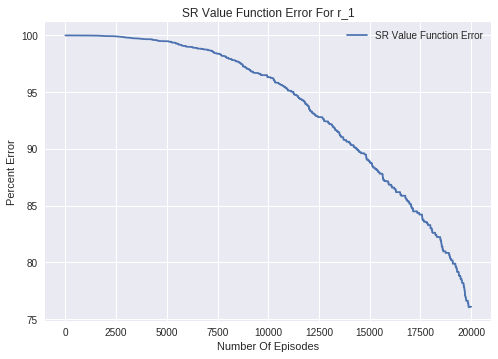

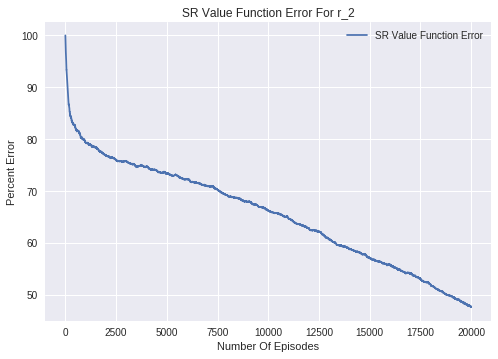

In [0]:
plt.plot(error_est[:20000]*100/error_est[0], label="SR Value Function Error")
plt.title('SR Value Function Error For r_1')
plt.xlabel('Number Of Episodes')
plt.ylabel('Percent Error')
plt.legend()
plt.show()

plt.figure()
plt.plot(error_est[20000:]*100/error_est[20000], label="SR Value Function Error")
plt.title('SR Value Function Error For r_2')
plt.xlabel('Number Of Episodes')
plt.ylabel('Percent Error')
plt.legend()
plt.show()

We can see from each plot that the percent error is decreasing with more training. It is also important to note that the errror is decreasing much faster in the second plot (i.e. for $r_2$). In the first plot the error decreases to slightly above $75\%$ But in the second plot the error decreases to a little more than $45\%$. We first want to comment on how we are calculating these percent errors so that there is no confusion later on. The ***Percentage*** here is just a rescaling of values so that we have a way of comparing the rate that the error is decreasing in these $2$ plots. The rescaling is as follows:


1.   We take the first element of the error function to be the max ($100\%$) error.
2.   We then rescale other values with respect to that first value.

In this way we can see how fast the error values are decreasing compared to the initial error , hence developing a measure to compare these $2$ plots. Now, we would like to address why we observe this faster rate of decrease in the second plot.<br>
This is because although we have changed the reward function, but the feature map is not being effected by it. The feature map is getting more accurate even! Since it begins the training for $r_2$ while having had $20,000$ episodes of training. The weights $w$ however, do get effected by this change, and that is why we need to keep learning their values but the features accuracy is higher and hence we observe a faster convergence in the second plot. If we plot the above process in one continuous $40,000$ episodes task, we have the following plot: (there is no rescaling below, just the norm of the difference between the SR method and the ground truth)



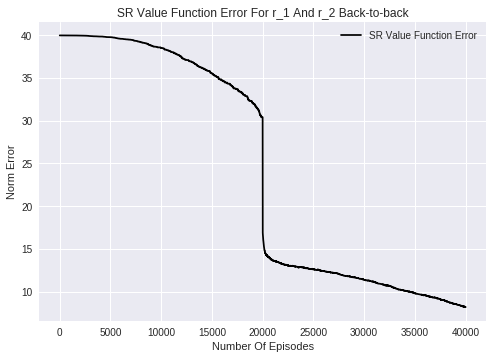

In [0]:
plt.figure()
plt.plot(error_est,color=(0,0,0), label="SR Value Function Error" )
plt.title('SR Value Function Error For r_1 And r_2 Back-to-back')
plt.xlabel('Number Of Episodes')
plt.ylabel('Norm Error')
plt.legend()
plt.show()

In this plot we can see that the learning of the value function has not been interrupted by the change in the reward function. The error of the value function is decreasing, regardless and in fact, as mentioned before, with a higher rate.

Now lets focus on what happens to the $\mathrm{TD}(0)$ method under the same setting. First lets investigate the quality of the learning. Below we have the plots of the error of the value functions learned under $\mathrm{TD}(0)$ method for reward functions $r_1$ and $r_2$. We will again enforce our rescaling procedure (that was explained before when analyzing the SR plots) for the plots below:

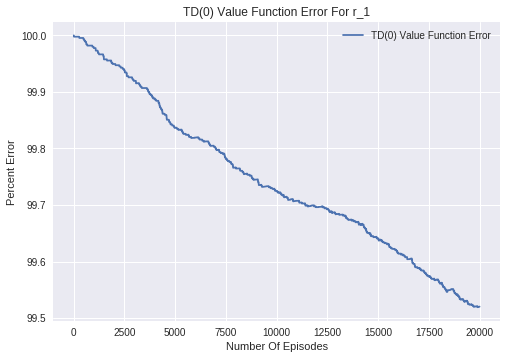

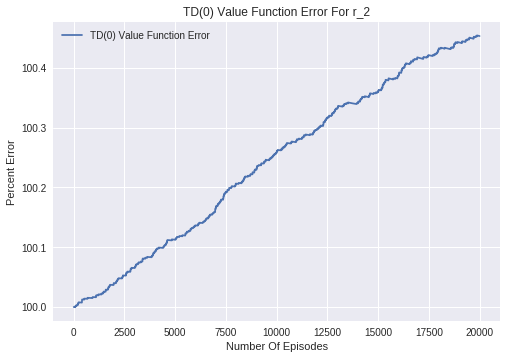

In [0]:
plt.plot(error_TD_change[:20000]*100/error_TD_change[0], label="TD(0) Value Function Error")
plt.title('TD(0) Value Function Error For r_1')
plt.xlabel('Number Of Episodes')
plt.ylabel('Percent Error')
plt.legend()
plt.show()

plt.figure()
plt.plot(error_TD_change[20000:]*100/error_TD_change[20000], label="TD(0) Value Function Error")
plt.title('TD(0) Value Function Error For r_2')
plt.xlabel('Number Of Episodes')
plt.ylabel('Percent Error')
plt.legend()
plt.show()


We can see here, from our plots above, that the vanilla $\mathrm{TD}(0)$ method is not fast enough in comparison to the **SR** method we saw before. We also not that it is not robust towards the change in the reward function. We can see that for the first $20,000$ episodes, the model's value function error is decreasing (although slowly) however once the reward function changes, the model can not recover and the error starts spiking up.  Below we are going to put the error values of these two methods on one graph for further analysis/comments. (there is no rescaling below, just the norm of the difference of the SR method and the ground truth)

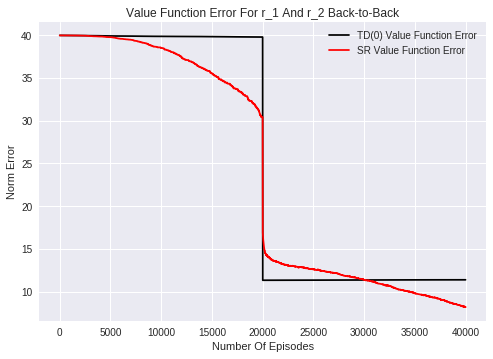

In [0]:
plt.figure()
plt.plot(error_TD_change, color=(0,0,0), label="TD(0) Value Function Error")
plt.plot(error_est, color=(1,0,0), label="SR Value Function Error")
plt.title('Value Function Error For r_1 And r_2 Back-to-Back')
plt.xlabel('Number Of Episodes')
plt.ylabel('Norm Error')
plt.legend()
plt.show()

Here the error for the $\mathrm {TD}(0)$ value function, looks somewhat like a straight line. However, in our previous analysis we have seen that they are not straight lines at all. In fact, the first part is a decreasing function and the second part is an increasing one. We see them as horizontal lines here due to the low variance they have in comparison to the SR and the scale of the plot.

As mentioned before the $\mathrm {TD}(0)$ completely looses to the **SR** approach in $2$ categories.


1.   Speed of convergence
2.   Robustness to the change in the reward function

As seen above (and in previous plots) we can see that in comparison to the **SR** approach the vanilla $\mathrm {TD}(0)$ method has a much lower decrease in its error as we train the model for more and more episodes. The change is so small that in comparison it seems linear.

Also once the reward function changed, the vanilla $\mathrm {TD}(0)$ method could not recover and its error started spiking up. But in the **SR** approach this change in the reward function was not an issue for the model and the error decreased even faster.

This concludes our report on the robustness of **SR** towards change in the reward function, and its speed in learning the value function in comparison to the vanilla $\mathrm {TD}(0)$. 



## 5. Eigendecomposition
In this section we will compute the approximate SR matrix for the [$8\times 8$ FrozenLake environment](https://gym.openai.com/envs/FrozenLake8x8-v0/).  Given the SR matrix, we will compute its eigendecomposition and plot its eigenvectors.

We begin by creating the $8\times 8$ FrozenLake environment where the actions are deterministic (i.e. there is no slipperiness). Below is the code for that initialization.

In [0]:
from gym.envs.registration import register
register(
    id='FrozenLakeNS8-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '8x8', 'is_slippery': False},
    max_episode_steps=100,
)


Now we are going to approximate the SR matrix by exploring the environment for $100,000$ episodes of maximum $100$ steps. Our learning rate here is $0.001$ and our $\gamma=0.9$. Once our approximation is over we then compute the eigendecomposition of the SR matrix. We will use these values later on to plot the eigenvectors.

In [0]:
M=np.zeros([64,64])
rl=0.001
epochs=100000
error=np.zeros(epochs)
gamma=0.9
for i in range(epochs):
  env = gym.make('FrozenLakeNS8-v0')
  observation_old=env.reset()
  for t in range(100):
    observation_new, reward, done, info = env.step(env.action_space.sample())
    M[observation_old,:]=M[observation_old,:]+rl*(gamma*M[observation_new,:]-M[observation_old,:])
    M[observation_old,observation_old]=M[observation_old,observation_old]+rl
    observation_old=observation_new
  if (i/epochs)*100%10==0:
    print('Processing ', (i/epochs)*100, "% of the work.")
w, v = LA.eig(M)

Processing  0.0 % of the work.
Processing  10.0 % of the work.
Processing  20.0 % of the work.
Processing  30.0 % of the work.
Processing  40.0 % of the work.
Processing  50.0 % of the work.
Processing  60.0 % of the work.
Processing  70.0 % of the work.
Processing  80.0 % of the work.
Processing  90.0 % of the work.


Below we have plotted all $64$ eigenvectors of SR eigendecomposition. Here we can clearly see the localization properties around obstacles/bottlenecks (as we can also observe from [figure [7]](https://papers.nips.cc/paper/5340-design-principles-of-the-hippocampal-cognitive-map.pdf)). The obstacles in this environment are basically the holes with a slight difference that the agent can enter them but cannot leave them. 

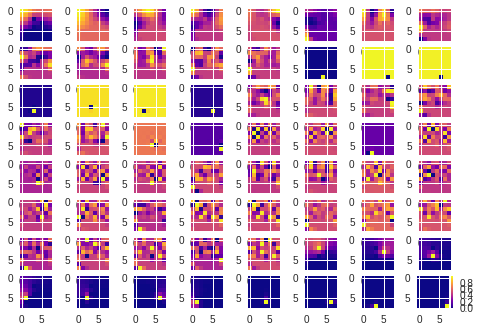

In [0]:

plt.subplots(8,8)
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(np.real(v[:,i]).reshape(8,8),cmap='plasma')
plt.colorbar()
plt.show()

In order to better understand the above plots we suggest to look at the [environment setting](https://gym.openai.com/envs/FrozenLake8x8-v0/) or take a look at the map we have provided here, with the holes (the obstacles) colored **white**, the goal state colored **orange** and the rest of the states in **black**.

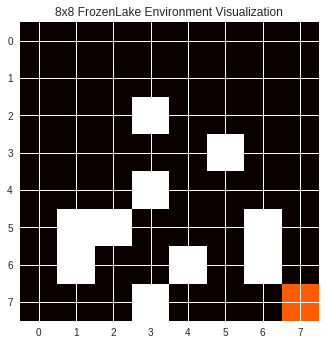

In [0]:
env_visual=np.zeros([8,8])
env_visual[2,3]=1
env_visual[3,5]=1
env_visual[4,3]=1
env_visual[5,1]=1
env_visual[5,2]=1
env_visual[5,6]=1
env_visual[6,1]=1
env_visual[6,4]=1
env_visual[6,6]=1
env_visual[7,3]=1
env_visual[7,7]=0.5
plt.imshow(env_visual,cmap='hot')
plt.title('8x8 FrozenLake Environment Visualization')
plt.show()

## Referances


1.   Dayan, Peter. "Improving generalization for temporal difference learning: The successor representation." Neural Computation 5.4 (1993): 613-624. *[link](https://www.mitpressjournals.org/doi/abs/10.1162/neco.1993.5.4.613)*
2.   Sutton, Richard S., et al. "Horde: A scalable real-time architecture for learning knowledge from unsupervised sensorimotor interaction." The 10th International Conference on Autonomous Agents and Multiagent Systems-Volume 2. International Foundation for Autonomous Agents and Multiagent Systems, 2011. *[link](http://incompleteideas.net/papers/horde-aamas-11.pdf)*
3.   Stachenfeld, Kimberly L., Matthew Botvinick, and Samuel J. Gershman. "Design principles of the hippocampal cognitive map." Advances in neural information processing systems. 2014. *[link](https://papers.nips.cc/paper/5340-design-principles-of-the-hippocampal-cognitive-map)*
4.   Barreto, André, et al. "Successor features for transfer in reinforcement learning." Advances in neural information processing systems. 2017. *[link text](http://papers.nips.cc/paper/6994-successor-features-for-transfer-in-reinforcement-learning)*

